## Import the model CLIP

In [1]:
from transformers import CLIPProcessor, CLIPModel
import torch
from tqdm.notebook import tqdm
from torch import nn
import clip

In [2]:


# Load the model and processor
device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training



In [ ]:

import sys

sys.path.append("/mnt/c/Users/Utente/Desktop/image_similarity_search")
from typing import Literal, Tuple
import os
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import clip

class ImageDataset(Dataset):
    def __init__(self, image_paths, descriptions,transform=None):
        self.image_paths = image_paths
        self.description = clip.tokenize(descriptions,truncate=True)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image using PIL
        
        img_path = "/mnt/c/Users/Utente/Desktop/image_similarity_search/data/interim/images/" + self.image_paths[idx]
        
        #print(f"Attempting to open image at path: {img_path}")  # Debugging line
        image = Image.open(img_path).convert("RGB")  
        
        #Load the text description
        description = self.description[idx]
        
        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)


    

              
        return image , description

def get_loader(
    path: str, batch_size: int = 64, shuffle=True
) -> DataLoader:
    """
    Returns a DataLoader object for the dataset at the specified path.
    """

    transform = transforms.Compose([
        transforms.Resize((224, 224)),   
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    df = pd.read_csv(path)

    ##CHANGE TO DROPNA
    df["DESCRIPTION"] = df["DESCRIPTION"].fillna("").astype(str)
    CPUs = os.cpu_count()
    dataset = ImageDataset(df["IMAGE_PATH"],df["DESCRIPTION"] ,transform=transform)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,num_workers=CPUs)

    return loader

# Load the data
train_dataloader = get_loader("/mnt/c/Users/Utente/Desktop/image_similarity_search/data/processed/train.csv", batch_size=64)
test_dataloader = get_loader("/mnt/c/Users/Utente/Desktop/image_similarity_search/data/processed/test.csv", batch_size=16)



In [4]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

In [5]:
if device == "cpu":
  model.float()
else :
  clip.model.convert_weights(model)

In [6]:
device

'cuda:0'

In [7]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6,betas=(0.9,0.98),eps=1e-6,weight_decay=0.4) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset


In [8]:
#define the number of epochs
num_epochs = 20

# Early Stopping
patience = 5  # Numero massimo di epoche senza miglioramenti
best_val_loss = float("inf")
no_improvement = 0


#training loop
for epoch in range(num_epochs):
    model.train()
    #plotting the progress bar  
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    #iterate over the training dataloader
    train_loss=0
    val_loss=0
    for batch in pbar:
         #set the gradients to zero
        optimizer.zero_grad()
        #load the images and texts
        images,texts = batch 

        images= images.to(device)

        texts = texts.to(device)
    
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        
        train_loss+=total_loss.item()
        
        # Backward pass
        total_loss.backward()

        optimizer.step()

    avg_train_loss = train_loss/len(train_dataloader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs},Train Loss: {avg_train_loss:.4f}")
    #validation step
    model.eval()
    with torch.no_grad():
        #iterate over the test dataloader
        for batch in test_dataloader:
            images, texts = batch
            images= images.to(device)
            texts = texts.to(device)
        
            logits_per_image, logits_per_text = model(images, texts)
            
            # Compute loss
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            val_loss+=total_loss.item()

    avg_val_loss = val_loss/len(test_dataloader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss:.4f}")

     # Check Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
        # Salva il modello migliore
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"/mnt/c/Users/Utente/Desktop/image_similarity_search/image_similarity_search/experiments/clipmodel_5.pt") #just change to your preferred folder/filename
        print("Validation loss improved. Model saved.")
    else:
        no_improvement += 1
        print(f"No improvement for {no_improvement} epoch(s).")

    if no_improvement >= patience:
        print("Early stopping triggered.")
        break
        

    #update the progress bar
    pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/20,Train Loss: 1.0796
Epoch 1/20, Val Loss: 0.3006
Validation loss improved. Model saved.


  0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/20,Train Loss: 0.5959
Epoch 2/20, Val Loss: 0.2317
Validation loss improved. Model saved.


  0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/20,Train Loss: 0.4169
Epoch 3/20, Val Loss: 0.2319
No improvement for 1 epoch(s).


  0%|          | 0/177 [00:00<?, ?it/s]

Epoch 4/20,Train Loss: 0.3304
Epoch 4/20, Val Loss: 0.2136
Validation loss improved. Model saved.


  0%|          | 0/177 [00:00<?, ?it/s]

Epoch 5/20,Train Loss: 0.2832
Epoch 5/20, Val Loss: 0.2529
No improvement for 1 epoch(s).


  0%|          | 0/177 [00:00<?, ?it/s]

Epoch 6/20,Train Loss: 0.2586
Epoch 6/20, Val Loss: 0.2416
No improvement for 2 epoch(s).


  0%|          | 0/177 [00:00<?, ?it/s]

Epoch 7/20,Train Loss: 0.2320
Epoch 7/20, Val Loss: 0.2555
No improvement for 3 epoch(s).


  0%|          | 0/177 [00:00<?, ?it/s]

Epoch 8/20,Train Loss: 0.2257
Epoch 8/20, Val Loss: 0.2403
No improvement for 4 epoch(s).


  0%|          | 0/177 [00:00<?, ?it/s]

Epoch 9/20,Train Loss: 0.2238
Epoch 9/20, Val Loss: 0.2578
No improvement for 5 epoch(s).
Early stopping triggered.


In [3]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
def load_finetuned_model(model_path, device):
    model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, preprocess

def compute_embeddings(model, dataloader, device):
    embeddings = []
    images_list = []  # To store original images for visualization
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing Embeddings"):
            images, _ = batch
            images = images.to(device)
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=1, keepdim=True)  # Normalize embeddings
            embeddings.append(image_features.cpu().numpy())
            images_list.extend(images.cpu())  # Store original images
    return np.vstack(embeddings), images_list

def find_most_similar(query_image_path,query_embedding, all_embeddings, dataloader_images, top_k=3):
    """
    Find the top K most similar images and display them.

    Parameters:
        query_embedding (numpy.ndarray): Embedding of the query image.
        all_embeddings (numpy.ndarray): All embeddings from the test dataloader.
        dataloader_images (list): List of images corresponding to the embeddings.
        top_k (int): Number of most similar images to retrieve.

    Returns:
        top_indices (list): Indices of the top K most similar images.
        similarities (list): Similarity scores of the top K most similar images.
    """
    # Compute cosine similarity
    similarities = cosine_similarity(query_embedding, all_embeddings)
    # Get top K most similar images exclude the query image itself
    top_indices=np.argsort(similarities[0])[-top_k-1:-1][::-1]
    

    # Display the query image and top similar images
    def display_images(query_image_path, similar_images, similarities):
        fig, axes = plt.subplots(1, top_k + 1, figsize=(5 * (top_k + 1), 5))
        query_image = plt.imread(query_image_path)
        # Query image
        axes[0].imshow(query_image)  # Convert tensor to image format
        axes[0].set_title("Query Image")
        axes[0].axis("off")

        # Most similar images
        for i, (img, sim) in enumerate(zip(similar_images, similarities)):
            axes[i + 1].imshow(img.permute(1, 2, 0))  # Convert tensor to image format
            axes[i + 1].set_title(f"Sim: {sim:.2f}")
            axes[i + 1].axis("off")

        plt.tight_layout()
        plt.show()

    # Retrieve the images corresponding to the top indices
    similar_images = [dataloader_images[idx] for idx in top_indices]

    # Display query image and most similar images
    display_images(query_image_path, similar_images, similarities[0][top_indices])
    

    return top_indices, similarities[0][top_indices]

/tmp/ipykernel_1082/3808846017.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Computing Embeddings:   0%|          | 0/177 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.654902..0.9764706].


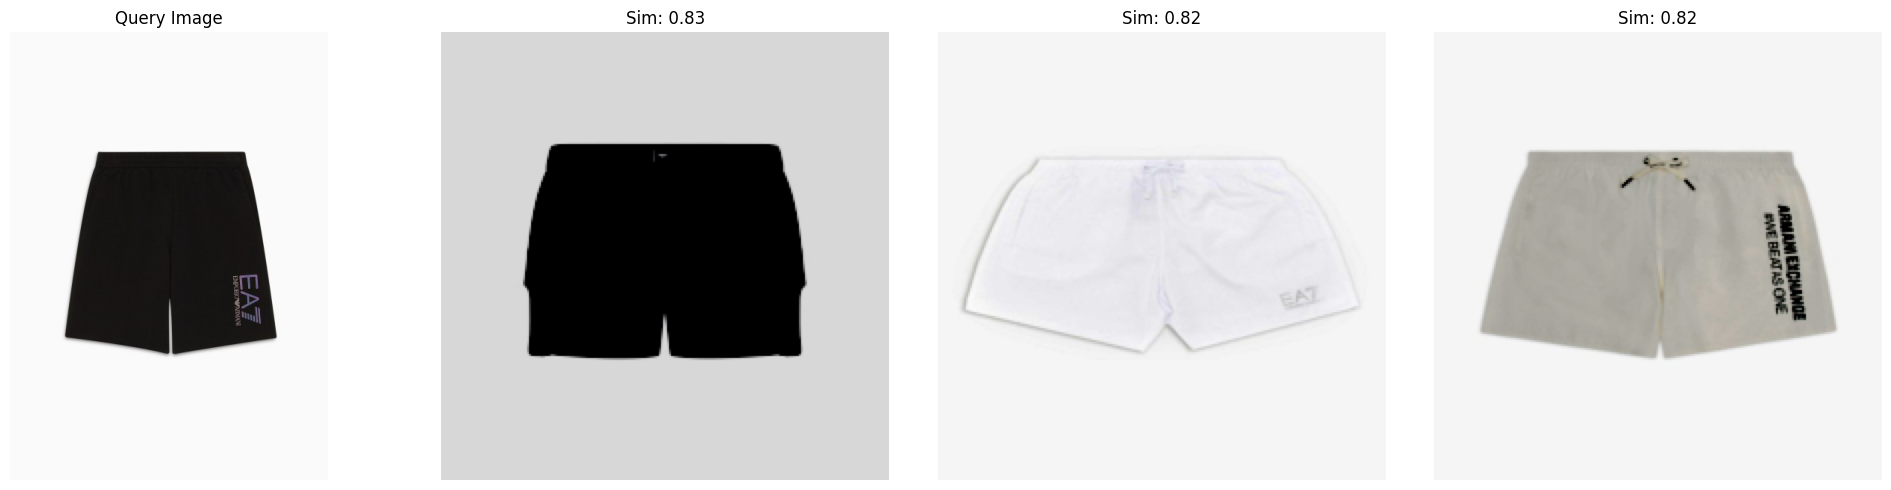

Top 3 most similar images indices: [ 288 1758  564]
Similarities: [0.82655358 0.82043998 0.81500284]


In [4]:
# Paths and settings
model_path = "/mnt/c/Users/Utente/Desktop/image_similarity_search/image_similarity_search/experiments/clipmodel_10.pt"  # Path to the fine-tuned model
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load the fine-tuned model
model, preprocess = load_finetuned_model(model_path, device)

# Compute embeddings for test dataset
test_embeddings, test_images = compute_embeddings(model, test_dataloader, device)

# Query image preprocessing
from PIL import Image
query_image_path = "/mnt/c/Users/Utente/Desktop/image_similarity_search/data/interim/images/ecommerce/3DBS53_BJ05Z_1200/SS2024/transform.EcomAr-3DBS53_BJ05Z_1200-SS2024-F.600.jpg"
query_image = preprocess(Image.open(query_image_path)).unsqueeze(0).to(device)

# Compute query embedding
with torch.no_grad():
    query_embedding = model.encode_image(query_image)
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)  # Normalize embedding
    query_embedding = query_embedding.cpu().numpy()

# Find top 3 most similar images
top_indices, similarities = find_most_similar(
    query_image_path,query_embedding, test_embeddings, test_images, top_k=3
)
print(f"Top 3 most similar images indices: {top_indices}")
print(f"Similarities: {similarities}")

In [1]:
import torch
print(torch.__version__)

2.4.1+cu124
